# Test MiniGrid sequential tasks with standard PPO

Default Jupyter settings

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
%autoreload 2

Import libraries

In [5]:
import sys, os, time
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from datetime import date

import pickle
import torch
from arguments_rl import get_args

from collections import deque
from rl_module.a2c_ppo_acktr.envs import make_vec_envs
from rl_module.a2c_ppo_acktr.storage import RolloutStorage
from rl_module.train_ppo import train_ppo
from stable_baselines3.common.utils import set_random_seed
from torch_ac.utils import DictList

# Gym MiniGrid specific
import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper
from gym.wrappers import Monitor

/Users/inigo/.local/share/virtualenvs/tfm-experiments-K5nk3NK1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# define wrapper for CNN Policies
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

## Test MLP Policy

Load arguments

In [7]:
args = {
'algo':'ppo',
'experiment':'minigrid-adam-doorkey-wallgap-lavagap',
'approach':'fine-tuning',#'blip',
'optimizer':'Adam',#'RMSProp',#'Adam',
'gail':False,
'gail_experts_dir':'./gail_experts',
'gail_batch_size':128,
'gail_epoch':5,
'lr':2.5e-4,#7e-4,#1e-4,
'eps':1e-8,#1e-5,
'gamma':0.99,
'use_gae':True,
'gae_lambda':0.95,#0.99,
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'seed':1,
'cuda_deterministic':False,
'num_processes':16,
'num_steps':128,#5,
'ppo_epoch':4,
'num_mini_batch':256,#8,#32,
'clip_param':0.2,#0.1,
'log_interval':10,
'save_interval':10,
'eval_interval':100,
'num_env_steps':5e5,
'env_name':'PongNoFrameskip-v4',
'log_dir':'./logs/',
'save_dir':'./trained_models/',
'no_cuda':True,
'use_proper_time_limits':False,
'recurrent_policy':False,
'use_linear_lr_decay':False,
'ewc_lambda':5000.0,
'ewc_online':False,
'ewc_epochs':100,
'num_ewc_steps':20,
'save_name':None,
'date':date.today(),
'task_id':None,
'single_task':False,
'F_prior':1e-15,
'input_padding':False,
'sample':False,
'samples':1,
# render arguments
'render_ckpt_path':'',
'render_task_idx':0,
'num_render_traj':1000
}

args = DictList(args)

args.cuda = not args.no_cuda and torch.cuda.is_available()

assert args.algo in ['a2c', 'ppo', 'acktr']
if args.recurrent_policy:
    assert args.algo in ['a2c', 'ppo'], \
        'Recurrent policy is not implemented for ACKTR'
conv_experiment = [
    'atari',
]

print(args)

{'algo': 'ppo', 'experiment': 'minigrid-adam-doorkey-wallgap-lavagap', 'approach': 'fine-tuning', 'optimizer': 'Adam', 'gail': False, 'gail_experts_dir': './gail_experts', 'gail_batch_size': 128, 'gail_epoch': 5, 'lr': 0.00025, 'eps': 1e-08, 'gamma': 0.99, 'use_gae': True, 'gae_lambda': 0.95, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'seed': 1, 'cuda_deterministic': False, 'num_processes': 16, 'num_steps': 128, 'ppo_epoch': 4, 'num_mini_batch': 256, 'clip_param': 0.2, 'log_interval': 10, 'save_interval': 10, 'eval_interval': 100, 'num_env_steps': 500000.0, 'env_name': 'PongNoFrameskip-v4', 'log_dir': './logs/', 'save_dir': './trained_models/', 'no_cuda': True, 'use_proper_time_limits': False, 'recurrent_policy': False, 'use_linear_lr_decay': False, 'ewc_lambda': 5000.0, 'ewc_online': False, 'ewc_epochs': 100, 'num_ewc_steps': 20, 'save_name': None, 'date': datetime.date(2023, 1, 13), 'task_id': None, 'single_task': False, 'F_prior': 1e-15, 'input_padding': Fal

In [9]:
# Split

if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    log_name = '{}_{}_{}_{}'.format(args.date, args.experiment, args.approach,args.seed)
elif args.approach == 'ewc' in args.approach:
    log_name = '{}_{}_{}_{}_lamb_{}'.format(args.date, args.experiment, args.approach, args.seed, args.ewc_lambda)
elif args.approach == 'blip':
    log_name = '{}_{}_{}_{}_F_prior_{}'.format(args.date, args.experiment, args.approach, args.seed, args.F_prior)

if args.experiment in conv_experiment:
    log_name = log_name + '_conv'

# Seed
set_random_seed(args.seed)

# Inits
if args.cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

device = torch.device("cuda" if args.cuda else "cpu")

#taskcla = [(0,14), (1,18), (2,18), (3,18), (4,18), (5,6)]
#task_sequences = [(0, 'KungFuMasterNoFrameskip-v4'), (1, 'BoxingNoFrameskip-v4'), (2, 'JamesbondNoFrameskip-v4'), (3, 'KrullNoFrameskip-v4'), (4, 'RiverraidNoFrameskip-v4'), (5, 'SpaceInvadersNoFrameskip-v4')]

taskcla = [(0,7), (1,7), (2,7)]
task_sequences = [
    (0, 'MiniGrid-DoorKey-6x6-v0'), 
    (1, 'MiniGrid-WallGapS6-v0'), 
    (2, 'MiniGrid-LavaGapS6-v0')
    ]

# hard coded for atari environment
#obs_shape = (4,84,84)

# for FlatObsWrapper Minigrid environment
obs_shape = (2739,)

if args.approach == 'blip':
    from rl_module.ppo_model import QPolicy
    print('using fisher prior of: ', args.F_prior)
    actor_critic = QPolicy(obs_shape,
        taskcla,
        base_kwargs={'F_prior': args.F_prior, 'recurrent': args.recurrent_policy}).to(device)
else:
    from rl_module.ppo_model import Policy
    actor_critic = Policy(obs_shape,
        taskcla,
        base_kwargs={'recurrent': args.recurrent_policy}).to(device)

# Args -- Approach
if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    from rl_module.ppo import PPO as approach

    agent = approach(actor_critic,
            args.clip_param,
            args.ppo_epoch,
            args.num_mini_batch,
            args.value_loss_coef,
            args.entropy_coef,
            lr=args.lr,
            eps=args.eps,
            max_grad_norm=args.max_grad_norm,
            use_clipped_value_loss=True,
            optimizer=args.optimizer)
elif args.approach == 'ewc':
    from rl_module.ppo_ewc import PPO_EWC as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        ewc_lambda= args.ewc_lambda,
        online = args.ewc_online,
        optimizer=args.optimizer)

elif args.approach == 'blip':
    from rl_module.ppo_blip import PPO_BLIP as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        optimizer=args.optimizer)

In [9]:
tr_reward_arr = []
te_reward_arr = {}

for _type in (['mean', 'max', 'min']):
    te_reward_arr[_type] = {}
    for idx in range(len(taskcla)):
        te_reward_arr[_type]['task' + str(idx)] = []

for task_idx,env_name in task_sequences:
    print(env_name)
    # renew optimizer
    agent.renew_optimizer()

    # FlatObsWrapper for MiniGrid
    envs = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=FlatObsWrapper)
    obs = envs.reset()

    rollouts = RolloutStorage(args.num_steps, args.num_processes,
                                    obs_shape, envs.action_space,
                                    actor_critic.recurrent_hidden_state_size)

    rollouts.obs[0].copy_(obs)
    rollouts.to(device)

    episode_rewards = deque(maxlen=10)
    num_updates = int(args.num_env_steps) // args.num_steps // args.num_processes

    train_ppo(actor_critic, agent, rollouts, task_idx, env_name, task_sequences, envs,  obs_shape, args, episode_rewards, tr_reward_arr, te_reward_arr, num_updates, log_name, device, wrapper_class=FlatObsWrapper)

    # post-processing
    if args.approach == 'fine-tuning':
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ft-fix':
        # fix the backbone
        for param in actor_critic.features.parameters():
            param.requires_grad = False
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ewc':
        agent.update_fisher(rollouts, task_idx)
        envs.close()
    elif args.approach == 'blip':
        agent.ng_post_processing(rollouts, task_idx)
        # save the model here so that bit allocation is saved
        save_path = os.path.join(args.save_dir, args.algo)
        torch.save(actor_critic.state_dict(),
            os.path.join(save_path, log_name + '_task_' + str(task_idx) + ".pth"))
        envs.close()

MiniGrid-DoorKey-6x6-v0
Task 0: Evaluation using 10 episodes: mean reward 0.00000 

len task_sequences :  3


  4%|▍         | 10/244 [00:36<13:56,  3.58s/it]

Updates 9, num timesteps 20480, FPS 567 
 Last 10 training episodes: mean/median reward 0.1/0.0, min/max reward 0.0/0.7



  8%|▊         | 20/244 [01:18<16:00,  4.29s/it]

Updates 19, num timesteps 40960, FPS 519 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0



 12%|█▏        | 30/244 [01:57<13:12,  3.70s/it]

Updates 29, num timesteps 61440, FPS 523 
 Last 10 training episodes: mean/median reward 0.3/0.2, min/max reward 0.0/0.9



 16%|█▋        | 40/244 [02:37<12:40,  3.73s/it]

Updates 39, num timesteps 81920, FPS 519 
 Last 10 training episodes: mean/median reward 0.7/0.7, min/max reward 0.4/0.9



 20%|██        | 50/244 [03:12<11:40,  3.61s/it]

Updates 49, num timesteps 102400, FPS 530 
 Last 10 training episodes: mean/median reward 0.9/1.0, min/max reward 0.8/1.0



 25%|██▍       | 60/244 [03:50<11:32,  3.76s/it]

Updates 59, num timesteps 122880, FPS 533 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 29%|██▊       | 70/244 [04:28<10:53,  3.75s/it]

Updates 69, num timesteps 143360, FPS 534 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0



 33%|███▎      | 80/244 [05:04<09:47,  3.58s/it]

Updates 79, num timesteps 163840, FPS 537 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 37%|███▋      | 90/244 [05:41<09:16,  3.61s/it]

Updates 89, num timesteps 184320, FPS 540 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0



 41%|████      | 99/244 [06:13<08:43,  3.61s/it]

Updates 99, num timesteps 204800, FPS 541 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 41%|████      | 100/244 [06:23<13:02,  5.43s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96675 

len task_sequences :  3


 45%|████▌     | 110/244 [07:03<08:40,  3.88s/it]

Updates 109, num timesteps 225280, FPS 532 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 49%|████▉     | 120/244 [07:39<07:51,  3.80s/it]

Updates 119, num timesteps 245760, FPS 534 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 53%|█████▎    | 130/244 [08:14<06:44,  3.54s/it]

Updates 129, num timesteps 266240, FPS 538 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 57%|█████▋    | 140/244 [08:49<06:04,  3.50s/it]

Updates 139, num timesteps 286720, FPS 541 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 61%|██████▏   | 150/244 [09:25<05:36,  3.58s/it]

Updates 149, num timesteps 307200, FPS 542 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0



 66%|██████▌   | 160/244 [10:01<04:53,  3.49s/it]

Updates 159, num timesteps 327680, FPS 544 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 70%|██████▉   | 170/244 [10:36<04:13,  3.43s/it]

Updates 169, num timesteps 348160, FPS 546 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0



 74%|███████▍  | 180/244 [11:11<03:44,  3.50s/it]

Updates 179, num timesteps 368640, FPS 548 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0



 78%|███████▊  | 190/244 [11:45<03:02,  3.39s/it]

Updates 189, num timesteps 389120, FPS 551 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 82%|████████▏ | 199/244 [12:16<02:31,  3.37s/it]

Updates 199, num timesteps 409600, FPS 553 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 82%|████████▏ | 200/244 [12:24<03:32,  4.82s/it]

Task 0: Evaluation using 10 episodes: mean reward 0.96475 

len task_sequences :  3


 86%|████████▌ | 210/244 [12:58<01:56,  3.41s/it]

Updates 209, num timesteps 430080, FPS 552 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 90%|█████████ | 220/244 [13:31<01:20,  3.37s/it]

Updates 219, num timesteps 450560, FPS 555 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 94%|█████████▍| 230/244 [14:05<00:47,  3.37s/it]

Updates 229, num timesteps 471040, FPS 557 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0



 98%|█████████▊| 240/244 [14:39<00:13,  3.37s/it]

Updates 239, num timesteps 491520, FPS 559 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 1.0/1.0



100%|██████████| 244/244 [14:52<00:00,  3.66s/it]

MiniGrid-WallGapS6-v0


Task 0: Evaluation using 10 episodes: mean reward 0.96375 

Task 1: Evaluation using 10 episodes: mean reward 0.00000 

len task_sequences :  3


  4%|▍         | 10/244 [00:35<13:45,  3.53s/it]

Updates 9, num timesteps 20480, FPS 575 
 Last 10 training episodes: mean/median reward 0.5/0.6, min/max reward 0.0/1.0



  8%|▊         | 20/244 [01:11<13:26,  3.60s/it]

Updates 19, num timesteps 40960, FPS 574 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 12%|█▏        | 30/244 [01:49<13:40,  3.84s/it]

Updates 29, num timesteps 61440, FPS 561 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 16%|█▋        | 40/244 [02:27<12:59,  3.82s/it]

Updates 39, num timesteps 81920, FPS 553 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 20%|██        | 50/244 [03:06<12:24,  3.84s/it]

Updates 49, num timesteps 102400, FPS 549 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 25%|██▍       | 60/244 [03:44<11:47,  3.85s/it]

Updates 59, num timesteps 122880, FPS 546 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 29%|██▊       | 70/244 [04:24<11:10,  3.86s/it]

Updates 69, num timesteps 143360, FPS 542 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 33%|███▎      | 80/244 [05:03<10:34,  3.87s/it]

Updates 79, num timesteps 163840, FPS 540 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 37%|███▋      | 90/244 [05:42<09:55,  3.87s/it]

Updates 89, num timesteps 184320, FPS 538 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/0.9



 41%|████      | 99/244 [06:17<09:14,  3.82s/it]

Updates 99, num timesteps 204800, FPS 537 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0

Task 0: Evaluation using 10 episodes: mean reward 0.95850 



 41%|████      | 100/244 [06:32<17:49,  7.43s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.94187 

len task_sequences :  3


 45%|████▌     | 110/244 [07:12<08:49,  3.95s/it]

Updates 109, num timesteps 225280, FPS 521 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 49%|████▉     | 120/244 [07:50<07:52,  3.81s/it]

Updates 119, num timesteps 245760, FPS 522 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 53%|█████▎    | 130/244 [08:29<07:18,  3.85s/it]

Updates 129, num timesteps 266240, FPS 522 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 57%|█████▋    | 140/244 [09:07<06:38,  3.83s/it]

Updates 139, num timesteps 286720, FPS 523 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 61%|██████▏   | 150/244 [09:46<06:00,  3.84s/it]

Updates 149, num timesteps 307200, FPS 524 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 66%|██████▌   | 160/244 [10:24<05:20,  3.82s/it]

Updates 159, num timesteps 327680, FPS 524 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 70%|██████▉   | 170/244 [11:03<04:53,  3.96s/it]

Updates 169, num timesteps 348160, FPS 524 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 74%|███████▍  | 180/244 [11:42<04:03,  3.81s/it]

Updates 179, num timesteps 368640, FPS 524 
 Last 10 training episodes: mean/median reward 1.0/1.0, min/max reward 0.9/1.0



 78%|███████▊  | 190/244 [12:20<03:16,  3.64s/it]

Updates 189, num timesteps 389120, FPS 525 
 Last 10 training episodes: mean/median reward 0.9/1.0, min/max reward 0.9/1.0



 82%|████████▏ | 199/244 [13:17<04:25,  5.89s/it]

Updates 199, num timesteps 409600, FPS 510 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0

Task 0: Evaluation using 10 episodes: mean reward 0.22850 



 82%|████████▏ | 200/244 [13:33<06:29,  8.85s/it]

Task 1: Evaluation using 10 episodes: mean reward 0.95438 

len task_sequences :  3


 86%|████████▌ | 210/244 [14:12<02:16,  4.02s/it]

Updates 209, num timesteps 430080, FPS 504 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 90%|█████████ | 220/244 [14:51<01:32,  3.84s/it]

Updates 219, num timesteps 450560, FPS 505 
 Last 10 training episodes: mean/median reward 0.9/1.0, min/max reward 0.9/1.0



 94%|█████████▍| 230/244 [15:28<00:52,  3.75s/it]

Updates 229, num timesteps 471040, FPS 507 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 98%|█████████▊| 240/244 [16:06<00:15,  3.79s/it]

Updates 239, num timesteps 491520, FPS 508 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



100%|██████████| 244/244 [16:22<00:00,  4.02s/it]

MiniGrid-LavaGapS6-v0


Task 0: Evaluation using 10 episodes: mean reward 0.96125 

Task 1: Evaluation using 10 episodes: mean reward 0.95250 

Task 2: Evaluation using 10 episodes: mean reward 0.00000 

len task_sequences :  3


  4%|▍         | 10/244 [00:39<15:37,  4.01s/it]

Updates 9, num timesteps 20480, FPS 514 
 Last 10 training episodes: mean/median reward 0.2/0.0, min/max reward 0.0/0.8



  8%|▊         | 20/244 [01:21<15:55,  4.27s/it]

Updates 19, num timesteps 40960, FPS 500 
 Last 10 training episodes: mean/median reward 0.1/0.0, min/max reward 0.0/0.9



 12%|█▏        | 30/244 [02:00<13:43,  3.85s/it]

Updates 29, num timesteps 61440, FPS 508 
 Last 10 training episodes: mean/median reward 0.4/0.0, min/max reward 0.0/0.9



 16%|█▋        | 40/244 [02:42<13:50,  4.07s/it]

Updates 39, num timesteps 81920, FPS 505 
 Last 10 training episodes: mean/median reward 0.6/0.8, min/max reward 0.0/0.9



 20%|██        | 50/244 [03:21<12:56,  4.00s/it]

Updates 49, num timesteps 102400, FPS 508 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.6/1.0



 25%|██▍       | 60/244 [03:59<11:46,  3.84s/it]

Updates 59, num timesteps 122880, FPS 513 
 Last 10 training episodes: mean/median reward 0.8/0.9, min/max reward 0.0/1.0



 29%|██▊       | 70/244 [04:39<11:35,  3.99s/it]

Updates 69, num timesteps 143360, FPS 512 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.0/1.0



 33%|███▎      | 80/244 [05:20<11:07,  4.07s/it]

Updates 79, num timesteps 163840, FPS 510 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.8/1.0



 37%|███▋      | 90/244 [06:03<11:41,  4.55s/it]

Updates 89, num timesteps 184320, FPS 506 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 41%|████      | 99/244 [06:44<10:43,  4.44s/it]

Updates 99, num timesteps 204800, FPS 500 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0

Task 0: Evaluation using 10 episodes: mean reward 0.20150 

Task 1: Evaluation using 10 episodes: mean reward 0.93938 



 41%|████      | 100/244 [07:07<23:39,  9.86s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.89875 

len task_sequences :  3


 45%|████▌     | 110/244 [07:47<08:59,  4.02s/it]

Updates 109, num timesteps 225280, FPS 481 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 49%|████▉     | 120/244 [08:25<07:53,  3.82s/it]

Updates 119, num timesteps 245760, FPS 486 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 53%|█████▎    | 130/244 [09:05<07:44,  4.07s/it]

Updates 129, num timesteps 266240, FPS 487 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 57%|█████▋    | 140/244 [09:46<06:59,  4.04s/it]

Updates 139, num timesteps 286720, FPS 489 
 Last 10 training episodes: mean/median reward 0.8/0.9, min/max reward 0.0/1.0



 61%|██████▏   | 150/244 [10:25<06:09,  3.93s/it]

Updates 149, num timesteps 307200, FPS 490 
 Last 10 training episodes: mean/median reward 0.7/0.8, min/max reward 0.0/1.0



 66%|██████▌   | 160/244 [11:05<05:37,  4.01s/it]

Updates 159, num timesteps 327680, FPS 492 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 70%|██████▉   | 170/244 [11:45<04:57,  4.02s/it]

Updates 169, num timesteps 348160, FPS 493 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.8/1.0



 74%|███████▍  | 180/244 [12:26<04:15,  4.00s/it]

Updates 179, num timesteps 368640, FPS 494 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 78%|███████▊  | 190/244 [13:06<03:32,  3.93s/it]

Updates 189, num timesteps 389120, FPS 495 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 82%|████████▏ | 199/244 [13:40<02:50,  3.79s/it]

Updates 199, num timesteps 409600, FPS 497 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0

Task 0: Evaluation using 10 episodes: mean reward 0.09300 

Task 1: Evaluation using 10 episodes: mean reward 0.93750 



 82%|████████▏ | 200/244 [14:00<06:22,  8.68s/it]

Task 2: Evaluation using 10 episodes: mean reward 0.75812 

len task_sequences :  3


 86%|████████▌ | 210/244 [14:40<02:19,  4.12s/it]

Updates 209, num timesteps 430080, FPS 488 
 Last 10 training episodes: mean/median reward 0.8/0.9, min/max reward 0.0/1.0



 90%|█████████ | 220/244 [15:22<01:39,  4.13s/it]

Updates 219, num timesteps 450560, FPS 488 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.8/0.9



 94%|█████████▍| 230/244 [16:02<00:57,  4.10s/it]

Updates 229, num timesteps 471040, FPS 489 
 Last 10 training episodes: mean/median reward 0.9/0.9, min/max reward 0.9/1.0



 98%|█████████▊| 240/244 [16:43<00:16,  4.04s/it]

Updates 239, num timesteps 491520, FPS 489 
 Last 10 training episodes: mean/median reward 0.8/0.9, min/max reward 0.0/1.0



100%|██████████| 244/244 [16:59<00:00,  4.18s/it]


Evaluate

In [19]:
from rl_module.evaluation import evaluate
args.seed = 2
print(task_sequences)
task_idx = task_sequences[-1][0]
ob_rms = None

print('Evaluating tasks:')
eval_episode_mean_rewards = evaluate(actor_critic, ob_rms, task_sequences, args.seed,
                            args.num_processes, args.log_dir, device, obs_shape, task_idx, args.gamma, wrapper_class=FlatObsWrapper, episodes=100)

[(0, 'MiniGrid-DoorKey-6x6-v0'), (1, 'MiniGrid-WallGapS6-v0'), (2, 'MiniGrid-LavaGapS6-v0')]
Evaluating tasks:
Task 0: Evaluation using 100 episodes: mean reward 0.10410 

Task 1: Evaluation using 100 episodes: mean reward 0.60331 

Task 2: Evaluation using 100 episodes: mean reward 0.91325 



## Test CNN Policy

In [67]:
args = {
'algo':'ppo',
'experiment':'minigrid-cnn-doorkey-wallgap-lavagap',
'approach':'fine-tuning',#'blip',
'optimizer':'Adam',#'RMSProp',#'Adam',
'gail':False,
'gail_experts_dir':'./gail_experts',
'gail_batch_size':128,
'gail_epoch':5,
'lr':2.5e-4,#7e-4,#1e-4,
'eps':1e-8,#1e-5,
'gamma':0.99,
'use_gae':True,
'gae_lambda':0.95,#0.99,
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'seed':1,
'cuda_deterministic':False,
'num_processes':16,
'num_steps':128,#5,
'ppo_epoch':4,
'num_mini_batch':256,#8,#32,
'clip_param':0.2,#0.1,
'log_interval':10,
'save_interval':10,
'eval_interval':100,
'num_env_steps':5e5,
'env_name':'PongNoFrameskip-v4',
'log_dir':'./logs/',
'save_dir':'./trained_models/',
'no_cuda':True,
'use_proper_time_limits':False,
'recurrent_policy':False,
'use_linear_lr_decay':False,
'ewc_lambda':5000.0,
'ewc_online':False,
'ewc_epochs':100,
'num_ewc_steps':20,
'save_name':None,
'date':date.today(),
'task_id':None,
'single_task':False,
'F_prior':1e-15,
'input_padding':False,
'sample':False,
'samples':1,
# render arguments
'render_ckpt_path':'',
'render_task_idx':0,
'num_render_traj':1000
}

args = DictList(args)

args.cuda = not args.no_cuda and torch.cuda.is_available()

assert args.algo in ['a2c', 'ppo', 'acktr']
if args.recurrent_policy:
    assert args.algo in ['a2c', 'ppo'], \
        'Recurrent policy is not implemented for ACKTR'
conv_experiment = [
    'atari',
]

print(args)

{'algo': 'ppo', 'experiment': 'minigrid-cnn-doorkey-wallgap-lavagap', 'approach': 'fine-tuning', 'optimizer': 'Adam', 'gail': False, 'gail_experts_dir': './gail_experts', 'gail_batch_size': 128, 'gail_epoch': 5, 'lr': 0.00025, 'eps': 1e-08, 'gamma': 0.99, 'use_gae': True, 'gae_lambda': 0.95, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'seed': 1, 'cuda_deterministic': False, 'num_processes': 16, 'num_steps': 128, 'ppo_epoch': 4, 'num_mini_batch': 256, 'clip_param': 0.2, 'log_interval': 10, 'save_interval': 10, 'eval_interval': 100, 'num_env_steps': 500000.0, 'env_name': 'PongNoFrameskip-v4', 'log_dir': './logs/', 'save_dir': './trained_models/', 'no_cuda': True, 'use_proper_time_limits': False, 'recurrent_policy': False, 'use_linear_lr_decay': False, 'ewc_lambda': 5000.0, 'ewc_online': False, 'ewc_epochs': 100, 'num_ewc_steps': 20, 'save_name': None, 'date': datetime.date(2023, 1, 13), 'task_id': None, 'single_task': False, 'F_prior': 1e-15, 'input_padding': Fals

In [68]:
# Split

if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    log_name = '{}_{}_{}_{}'.format(args.date, args.experiment, args.approach,args.seed)
elif args.approach == 'ewc' in args.approach:
    log_name = '{}_{}_{}_{}_lamb_{}'.format(args.date, args.experiment, args.approach, args.seed, args.ewc_lambda)
elif args.approach == 'blip':
    log_name = '{}_{}_{}_{}_F_prior_{}'.format(args.date, args.experiment, args.approach, args.seed, args.F_prior)

if args.experiment in conv_experiment:
    log_name = log_name + '_conv'

# Seed
set_random_seed(args.seed)

# Inits
if args.cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

device = torch.device("cuda" if args.cuda else "cpu")

#taskcla = [(0,14), (1,18), (2,18), (3,18), (4,18), (5,6)]
#task_sequences = [(0, 'KungFuMasterNoFrameskip-v4'), (1, 'BoxingNoFrameskip-v4'), (2, 'JamesbondNoFrameskip-v4'), (3, 'KrullNoFrameskip-v4'), (4, 'RiverraidNoFrameskip-v4'), (5, 'SpaceInvadersNoFrameskip-v4')]

taskcla = [(0,7), (1,7), (2,7)]
task_sequences = [
    (0, 'MiniGrid-DoorKey-6x6-v0'), 
    (1, 'MiniGrid-WallGapS6-v0'), 
    (2, 'MiniGrid-LavaGapS6-v0')
    ]

# hard coded for atari environment
#obs_shape = (4,84,84)

# for FlatObsWrapper Minigrid environment
#obs_shape = (2739,)
# for ImgRGBImgPartialObsWrapper Minigrid environment
obs_shape = (12, 56, 56)

if args.approach == 'blip':
    from rl_module.ppo_model import QPolicy
    print('using fisher prior of: ', args.F_prior)
    actor_critic = QPolicy(obs_shape,
        taskcla,
        base_kwargs={'F_prior': args.F_prior, 'recurrent': args.recurrent_policy}).to(device)
else:
    from rl_module.ppo_model import Policy
    actor_critic = Policy(obs_shape,
        taskcla,
        base_kwargs={'recurrent': args.recurrent_policy}).to(device)

# Args -- Approach
if args.approach == 'fine-tuning' or args.approach == 'ft-fix':
    from rl_module.ppo import PPO as approach

    agent = approach(actor_critic,
            args.clip_param,
            args.ppo_epoch,
            args.num_mini_batch,
            args.value_loss_coef,
            args.entropy_coef,
            lr=args.lr,
            eps=args.eps,
            max_grad_norm=args.max_grad_norm,
            use_clipped_value_loss=True,
            optimizer=args.optimizer)
elif args.approach == 'ewc':
    from rl_module.ppo_ewc import PPO_EWC as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        ewc_lambda= args.ewc_lambda,
        online = args.ewc_online,
        optimizer=args.optimizer)

elif args.approach == 'blip':
    from rl_module.ppo_blip import PPO_BLIP as approach

    agent = approach(
        actor_critic,
        args.clip_param,
        args.ppo_epoch,
        args.num_mini_batch,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        max_grad_norm=args.max_grad_norm,
        use_clipped_value_loss=True,
        optimizer=args.optimizer)

In [69]:
tr_reward_arr = []
te_reward_arr = {}

for _type in (['mean', 'max', 'min']):
    te_reward_arr[_type] = {}
    for idx in range(len(taskcla)):
        te_reward_arr[_type]['task' + str(idx)] = []

for task_idx,env_name in task_sequences:
    print(env_name)
    # renew optimizer
    agent.renew_optimizer()

    # FlatObsWrapper for MiniGrid
    envs = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=ImgRGBImgPartialObsWrapper)
    obs = envs.reset()

    rollouts = RolloutStorage(args.num_steps, args.num_processes,
                                    obs_shape, envs.action_space,
                                    actor_critic.recurrent_hidden_state_size)

    rollouts.obs[0].copy_(obs)
    rollouts.to(device)

    episode_rewards = deque(maxlen=10)
    num_updates = int(args.num_env_steps) // args.num_steps // args.num_processes

    train_ppo(actor_critic, agent, rollouts, task_idx, env_name, task_sequences, envs,  obs_shape, args, episode_rewards, tr_reward_arr, te_reward_arr, num_updates, log_name, device, wrapper_class=ImgRGBImgPartialObsWrapper)

    # post-processing
    if args.approach == 'fine-tuning':
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ft-fix':
        # fix the backbone
        for param in actor_critic.features.parameters():
            param.requires_grad = False
        if args.single_task == True:
            envs.close()
            break
        else:
            envs.close()
    elif args.approach == 'ewc':
        agent.update_fisher(rollouts, task_idx)
        envs.close()
    elif args.approach == 'blip':
        agent.ng_post_processing(rollouts, task_idx)
        # save the model here so that bit allocation is saved
        save_path = os.path.join(args.save_dir, args.algo)
        torch.save(actor_critic.state_dict(),
            os.path.join(save_path, log_name + '_task_' + str(task_idx) + ".pth"))
        envs.close()

MiniGrid-DoorKey-6x6-v0
Task 0: Evaluation using 10 episodes: mean reward 0.00000 

len task_sequences :  3


  4%|▍         | 10/244 [02:16<53:30, 13.72s/it]

Updates 9, num timesteps 20480, FPS 150 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0



  8%|▊         | 20/244 [04:34<51:46, 13.87s/it]

Updates 19, num timesteps 40960, FPS 149 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0



 12%|█▏        | 30/244 [06:50<48:56, 13.72s/it]

Updates 29, num timesteps 61440, FPS 149 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0



 16%|█▋        | 40/244 [09:12<48:11, 14.17s/it]

Updates 39, num timesteps 81920, FPS 148 
 Last 10 training episodes: mean/median reward 0.0/0.0, min/max reward 0.0/0.0



 20%|██        | 50/244 [11:36<45:51, 14.19s/it]

Updates 49, num timesteps 102400, FPS 146 
 Last 10 training episodes: mean/median reward 0.1/0.0, min/max reward 0.0/0.7



 21%|██        | 51/244 [11:50<45:32, 14.16s/it]

## Check MiniGrid vectorized environments

In [1]:
import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper
from gym.wrappers import Monitor

In [2]:
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

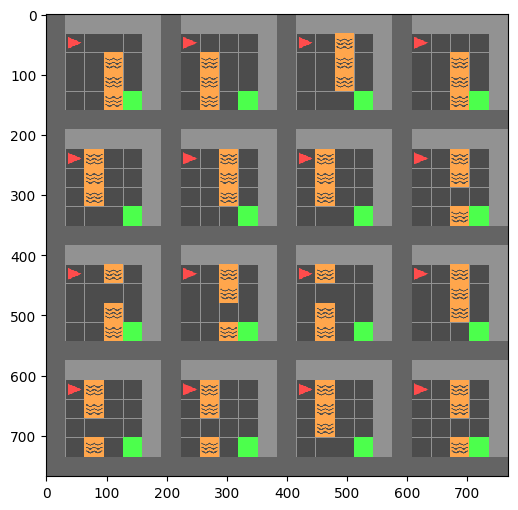

In [25]:
import matplotlib.pyplot as plt

#env_name = 'MiniGrid-DoorKey-6x6-v0'
#env_name = 'MiniGrid-WallGapS6-v0'
env_name = 'MiniGrid-LavaGapS6-v0'

# Create vectorized environment with wrapper class
vec_env = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=FlatObsWrapper)

# Plot snapshot of vectorized environment and check randomized init
vec_env.reset()
before_img = vec_env.render('rgb_array')

plt.figure(figsize = (6.,6.))
plt.imshow(before_img);

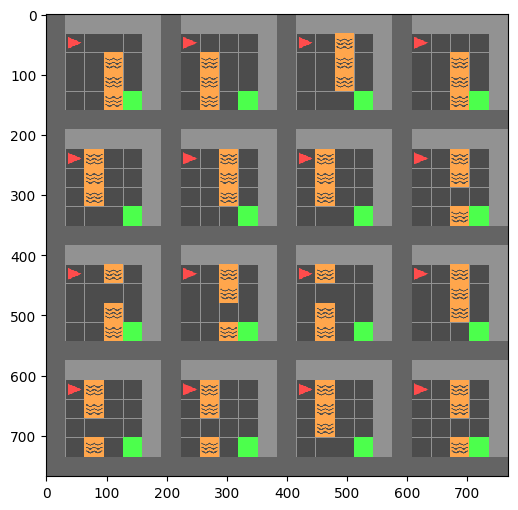

In [40]:
import matplotlib.pyplot as plt

#env_name = 'MiniGrid-DoorKey-6x6-v0'
#env_name = 'MiniGrid-WallGapS6-v0'
env_name = 'MiniGrid-LavaGapS6-v0'

# Create vectorized environment with wrapper class
vec_env = make_vec_envs(env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False, wrapper_class=ImgRGBImgPartialObsWrapper)

# Plot snapshot of vectorized environment and check randomized init
vec_env.reset()
before_img = vec_env.render('rgb_array')

plt.figure(figsize = (6.,6.))
plt.imshow(before_img);